In [1]:
import pickle 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

### Preprocessing

In [2]:
# load the data from csv, with its first row as header and load only the first three rows of data
A = pd.read_csv('A.csv', header=0, nrows=2) 
# build an incidence matrix with the first row of A as from, and the second row of A as to
from_, to_ = A.iloc[0], A.iloc[1]
from_ = from_.values.tolist()
to_ = to_.values.tolist()
edges = list(zip(from_, to_))
nodes = list(set(from_ + to_))


In [3]:
# build an incidence matrix with nodes as rows and edges as columns
incidence_matrix = np.zeros((len(nodes), len(edges)))
for i, node in enumerate(nodes):
    for e, edge in enumerate(edges):
        if node == edge[0]:
            incidence_matrix[i, e] = -1
        elif node == edge[1]:
            incidence_matrix[i, e] = 1

with open('water_network.pkl', 'rb') as f:
    b1, edge_signal, _, node_signal_head, hr = pickle.load(f)

edge_signal = np.array(edge_signal)
sign = np.sign(edge_signal)
edge_signal = -hr*sign*abs(edge_signal)**1.852

reverse edges for drawing

In [4]:
# reverse the edge direction in edges 
edges = [(e[1], e[0]) for e in edges]


# Make plots

In [5]:
# load position of nodes from a json file
import json
with open('zj_pos.json', 'r') as f:
    node_positions = json.load(f)

node_positions = [(pos_x, pos_y) for pos_x, pos_y in node_positions.values()]

move the location of source further to make it more visible

In [6]:
node_positions[-1] = 250, 500

In [7]:
x_train_id, y_train_id, x_test_id, y_test_id, pred_mean_id, pred_var_id, lower_id, upper_id, mse0_id, mse1_id, mae0_id, mae1_id,  nlpd0_id, nlpd1_id, all_mean_id, all_var_id = np.arange(0, 16)

In [8]:
seed = 2
orig_mean, orig_std = 4.5682, 8.8398

In [9]:
# load the learned results 
with open('../../results/water_network/water_network_matern_seed{}.pkl'.format(seed), 'rb') as f:
    results = pickle.load(f)

n0 = len(nodes)
train_ids = results[x_train_id]
node_train_ids, edge_train_ids = train_ids[train_ids<n0], train_ids[train_ids>=n0]-n0 
node_train_ids = node_train_ids.astype(int)
edge_train_ids = edge_train_ids.astype(int)
test_ids = results[x_test_id]
node_test_ids, edge_test_ids = test_ids[test_ids<n0], test_ids[test_ids>=n0]-n0
node_test_ids = node_test_ids.astype(int)
edge_test_ids = edge_test_ids.astype(int)

train_nodes = [nodes[i] for i in node_train_ids]
test_nodes = [nodes[i] for i in node_test_ids]
train_edges = [edges[i] for i in edge_train_ids]
test_edges = [edges[i] for i in edge_test_ids]



In [10]:
def drawing_function(node_signal, edge_flow, draw_colorbar=True):

    # true signal
    node_signal_true = (np.array(node_signal_head)-orig_mean)/orig_std
    edge_signal_true = (np.array(edge_signal) - orig_mean)/orig_std

    node_vmin= node_signal_true.min()
    node_vmax= node_signal_true.max()

    edge_vmin= edge_signal_true.min()
    edge_vmax= edge_signal_true.max()

    fig, ax = plt.subplots(dpi=300, figsize=(4,2.5))

    G = nx.DiGraph()
    
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    # switch the direction of the edges
    G = nx.reverse(G)
    pos = node_positions
    nx.draw_networkx(G, pos, nodelist=[], edgelist=[], with_labels=False)

    nx.draw_networkx_nodes(G, pos, nodelist=test_nodes, node_size=15, node_color=node_signal[node_test_ids], cmap=cmap0, vmin=node_vmin, vmax=node_vmax)
    nx.draw_networkx_edges(G, pos, edgelist=test_edges, node_size=15, edge_color=edge_flow[edge_test_ids], edge_cmap=cmap1, edge_vmin=edge_vmin, edge_vmax=edge_vmax, width=1.5, arrowstyle='-|>',arrowsize=5)

    nx.draw_networkx_nodes(G, pos, nodelist=train_nodes, node_size=10, node_color=node_signal[node_train_ids], cmap=cmap0, vmin=node_vmin, vmax=node_vmax, node_shape='s')
    nx.draw_networkx_edges(G, pos, edgelist=train_edges, node_size=10, edge_color=edge_flow[edge_train_ids], edge_cmap=cmap1, edge_vmin=edge_vmin, edge_vmax=edge_vmax, style='--', width=1.5, arrowstyle='-|>',arrowsize=5)

    # label the source node use draw_networkx_labels
    nx.draw_networkx_labels(G, pos, labels={nodes[-1]: 'Source'}, font_size=10, verticalalignment='bottom', horizontalalignment='right', font_color='k')
    
    ax.get_xaxis().set_ticks([])  
    ax.get_yaxis().set_ticks([])
    ax.axis('off')
 
    if draw_colorbar:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("left", size="3%", pad=0)
        fig.add_axes(cax)
        sm0 = plt.cm.ScalarMappable(cmap=cmap0, norm=plt.Normalize(vmin=node_vmin, vmax=node_vmax))
        cbar0 = plt.colorbar(sm0, cax=cax, shrink=0.3,)
        cbar0.ax.tick_params(labelsize=10,labelleft=True, labelright=False)
        cbar0.ax.set_title('Head', fontsize=10)
    
        
        cax = divider.new_vertical(size='4%', pad=0, pack_start=True)    
        fig.add_axes(cax)
        sm = plt.cm.ScalarMappable(cmap=cmap1, norm=plt.Normalize(vmin=edge_vmin, vmax=edge_vmax))
        cbar = plt.colorbar(sm, cax=cax, shrink=0.3,  orientation = 'horizontal')
        cbar.ax.tick_params(labelsize=10)
        cbar.ax.set_title('Flow', fontsize=10)

    return fig, ax


In [11]:
def drawing_function_var(node_signal, edge_flow):
    node_vmin= node_signal.min()
    node_vmax= node_signal.max()

    edge_vmin= edge_flow.min()
    edge_vmax= edge_flow.max()

    fig, ax = plt.subplots(dpi=300, figsize=(4,2.5))

    G = nx.DiGraph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    pos = node_positions
    nx.draw_networkx(G, pos, nodelist=[], edgelist=[], with_labels=False)

    # test nodes 
    nx.draw_networkx_nodes(G, pos, nodelist=test_nodes, node_size=15, node_color=node_signal[node_test_ids], cmap=cmap0, vmin=node_vmin, vmax=node_vmax)
    # test edges 
    nx.draw_networkx_edges(G, pos, edgelist=test_edges, node_size=15, edge_color=edge_flow[edge_test_ids], edge_cmap=cmap1, edge_vmin=edge_vmin, edge_vmax=edge_vmax, width=1.5, arrowstyle='-|>',arrowsize=5,)

    # train nodes
    nx.draw_networkx_nodes(G, pos, nodelist=train_nodes, node_size=10, node_color=node_signal[node_train_ids], cmap=cmap0, vmin=node_vmin, vmax=node_vmax, node_shape='s')
    # train edges
    nx.draw_networkx_edges(G, pos, edgelist=train_edges, node_size=10, edge_color=edge_flow[edge_train_ids], edge_cmap=cmap1, edge_vmin=edge_vmin, edge_vmax=edge_vmax, style='--', width=1.5, arrowstyle='-|>',arrowsize=5)
    
    # nx.draw_networkx_nodes(G, pos, nodelist=[nodes[-1]], node_size=15, node_color=node_signal[nodes[-1]], cmap=cmap0, vmin=node_vmin, vmax=node_vmax, node_shape='s', label='Source')

    # label the source node use draw_networkx_labels
    nx.draw_networkx_labels(G, pos, labels={nodes[-1]: 'Source'}, font_size=10, verticalalignment='bottom', horizontalalignment='right', font_color='k')
    
    ax.get_xaxis().set_ticks([])  
    ax.get_yaxis().set_ticks([])
    ax.axis('off')

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("left", size="3%", pad=0)
    fig.add_axes(cax)
    sm0 = plt.cm.ScalarMappable(cmap=cmap0, norm=plt.Normalize(vmin=node_vmin, vmax=node_vmax))
    cbar0 = plt.colorbar(sm0, cax=cax, shrink=0.3,)
    # cbar0.set_ticks()
    cbar0.ax.tick_params(labelsize=10,labelleft=True, labelright=False)
    cbar0.ax.set_title('Head', fontsize=10)

    cax = divider.new_vertical(size='4%', pad=0, pack_start=True)    
    fig.add_axes(cax)
    sm = plt.cm.ScalarMappable(cmap=cmap1, norm=plt.Normalize(vmin=edge_vmin, vmax=edge_vmax))
    cbar = plt.colorbar(sm, cax=cax, shrink=0.3,  orientation = 'horizontal')
    cbar.ax.tick_params(labelsize=10)
    cbar.ax.set_title('Flow', fontsize=10)

    return fig, ax


ground_truth

/tmp/ipykernel_2305316/4011309549.py:25: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, edgelist=test_edges, node_size=15, edge_color=edge_flow[edge_test_ids], edge_cmap=cmap1, edge_vmin=edge_vmin, edge_vmax=edge_vmax, width=1.5, arrowstyle='-|>',arrowsize=5)
/tmp/ipykernel_2305316/4011309549.py:28: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, edgelist=train_edges, node_size=10, edge_color=edge_flow[edge_train_ids], edge_cmap=cmap1, edge_vmin=edge_vmin, edge_vmax=edge_vmax, style='--', width=1.5, arrowstyle='-|>',arrowsize=5)


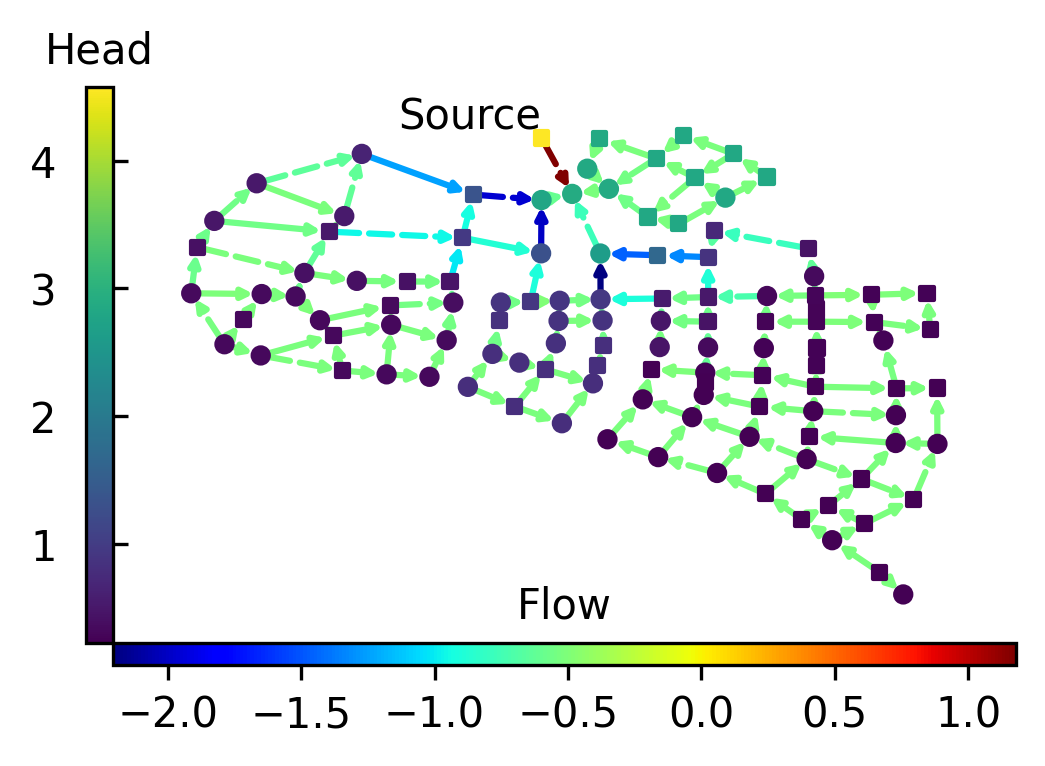

In [12]:

gt_node = (np.array(node_signal_head)-orig_mean)/orig_std
gt_edge = (np.array(edge_signal) - orig_mean)/orig_std
# gt_node = np.array(node_signal_head)
# gt_edge = np.array(edge_signal)
cmap0 = plt.cm.viridis
cmap1 = plt.cm.jet
fig, ax = drawing_function(gt_node, gt_edge, draw_colorbar=True)


mean

In [13]:
with open('../../results/water_network/water_network_matern-nonhc_seed{}.pkl'.format(seed), 'rb') as f:
    results = pickle.load(f)

all_mean = results[all_mean_id]
node_all_mean = all_mean[:n0] 
edge_all_mean = all_mean[n0:]
all_var = results[all_var_id]
node_all_var = all_var[:n0]
edge_all_var = all_var[n0:]

node_mean_train = all_mean[node_train_ids]
node_var_train = all_var[node_train_ids]
node_mean_test = all_mean[node_test_ids]
node_var_test = all_var[node_test_ids]

edge_mean_train = all_mean[edge_train_ids+n0]
edge_var_train = all_var[edge_train_ids+n0]
edge_mean_test = all_mean[edge_test_ids+n0]
edge_var_test = all_var[edge_test_ids+n0]

/tmp/ipykernel_2305316/4011309549.py:25: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, edgelist=test_edges, node_size=15, edge_color=edge_flow[edge_test_ids], edge_cmap=cmap1, edge_vmin=edge_vmin, edge_vmax=edge_vmax, width=1.5, arrowstyle='-|>',arrowsize=5)
/tmp/ipykernel_2305316/4011309549.py:28: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, edgelist=train_edges, node_size=10, edge_color=edge_flow[edge_train_ids], edge_cmap=cmap1, edge_vmin=edge_vmin, edge_vmax=edge_vmax, style='--', width=1.5, arrowstyle='-|>',arrowsize=5)


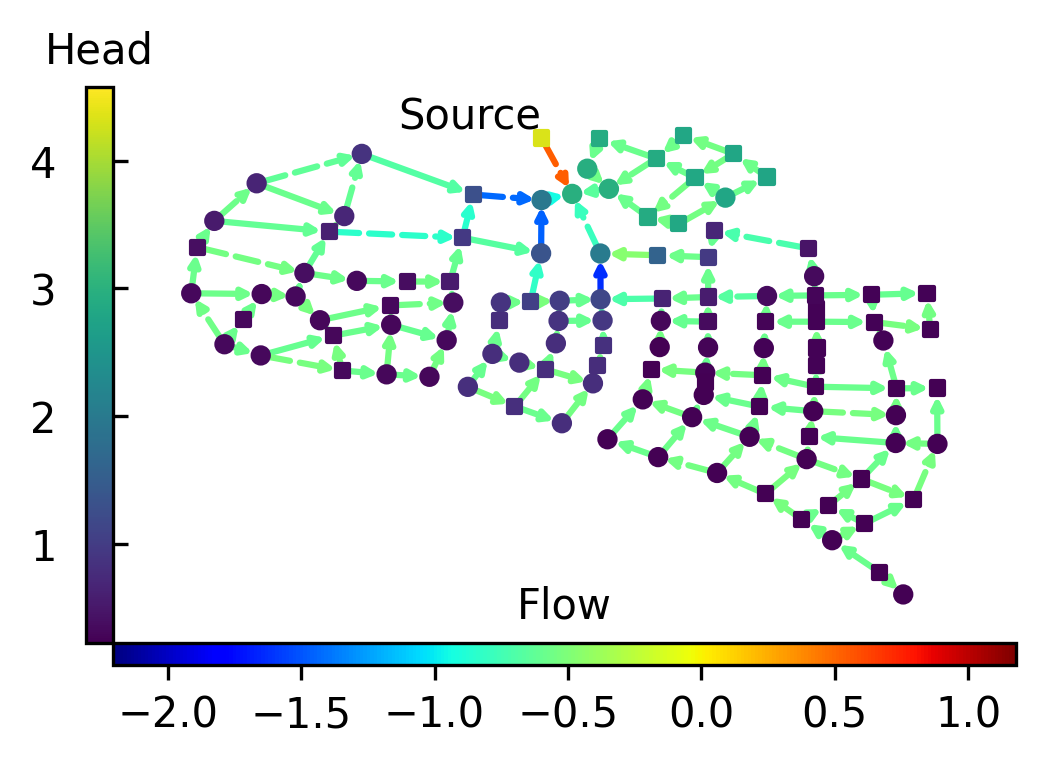

In [14]:
cmap0 = plt.cm.viridis
cmap1 = plt.cm.jet
fig, ax = drawing_function(node_all_mean, edge_all_mean, draw_colorbar=True)

/tmp/ipykernel_2305316/1002248140.py:19: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, edgelist=test_edges, node_size=15, edge_color=edge_flow[edge_test_ids], edge_cmap=cmap1, edge_vmin=edge_vmin, edge_vmax=edge_vmax, width=1.5, arrowstyle='-|>',arrowsize=5,)
/tmp/ipykernel_2305316/1002248140.py:24: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, edgelist=train_edges, node_size=10, edge_color=edge_flow[edge_train_ids], edge_cmap=cmap1, edge_vmin=edge_vmin, edge_vmax=edge_vmax, style='--', width=1.5, arrowstyle='-|>',arrowsize=5)


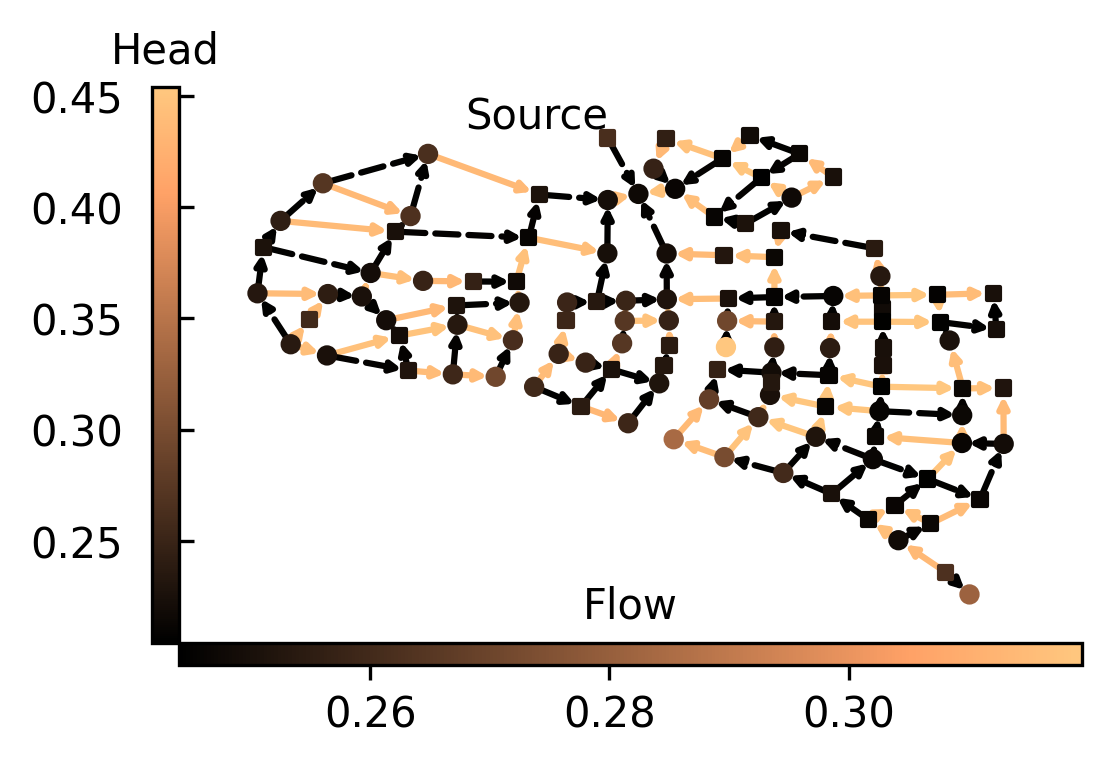

In [15]:
cmap0 = plt.colormaps.get_cmap('copper')
cmap1 = plt.colormaps.get_cmap('copper')
fig, ax = drawing_function_var(np.sqrt(node_all_var), np.sqrt(edge_all_var))

matern-HC

In [16]:
with open('../../results/water_network/water_network_matern_seed{}.pkl'.format(seed), 'rb') as f:
    results = pickle.load(f)

all_mean = results[all_mean_id]
node_all_mean = all_mean[:n0]
edge_all_mean = all_mean[n0:]
all_var = results[all_var_id]
node_all_var = all_var[:n0]
edge_all_var = all_var[n0:]

node_mean_train = all_mean[node_train_ids]
node_var_train = all_var[node_train_ids]
node_mean_test = all_mean[node_test_ids]
node_var_test = all_var[node_test_ids]

edge_mean_train = all_mean[edge_train_ids+n0]
edge_var_train = all_var[edge_train_ids+n0]
edge_mean_test = all_mean[edge_test_ids+n0]
edge_var_test = all_var[edge_test_ids+n0]

/tmp/ipykernel_2305316/4011309549.py:25: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, edgelist=test_edges, node_size=15, edge_color=edge_flow[edge_test_ids], edge_cmap=cmap1, edge_vmin=edge_vmin, edge_vmax=edge_vmax, width=1.5, arrowstyle='-|>',arrowsize=5)
/tmp/ipykernel_2305316/4011309549.py:28: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, edgelist=train_edges, node_size=10, edge_color=edge_flow[edge_train_ids], edge_cmap=cmap1, edge_vmin=edge_vmin, edge_vmax=edge_vmax, style='--', width=1.5, arrowstyle='-|>',arrowsize=5)


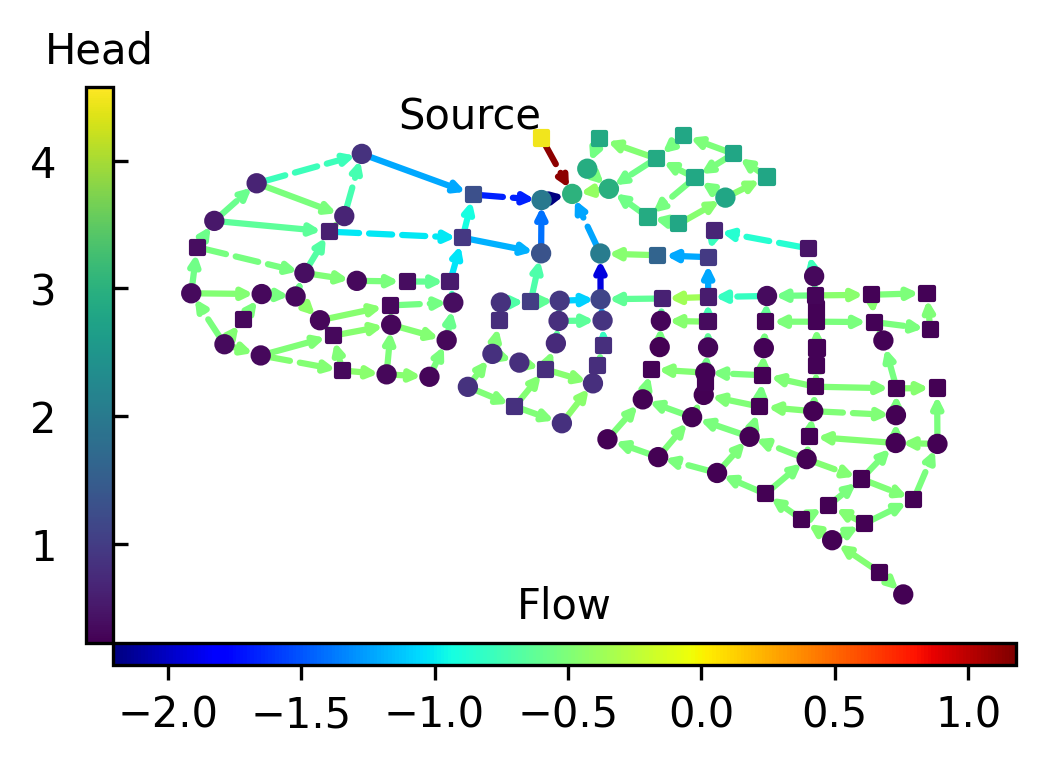

In [17]:
cmap0 = plt.cm.viridis
cmap1 = plt.cm.jet
fig, ax = drawing_function(node_all_mean, edge_all_mean, draw_colorbar=True)

/tmp/ipykernel_2305316/1002248140.py:19: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, edgelist=test_edges, node_size=15, edge_color=edge_flow[edge_test_ids], edge_cmap=cmap1, edge_vmin=edge_vmin, edge_vmax=edge_vmax, width=1.5, arrowstyle='-|>',arrowsize=5,)
/tmp/ipykernel_2305316/1002248140.py:24: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, edgelist=train_edges, node_size=10, edge_color=edge_flow[edge_train_ids], edge_cmap=cmap1, edge_vmin=edge_vmin, edge_vmax=edge_vmax, style='--', width=1.5, arrowstyle='-|>',arrowsize=5)


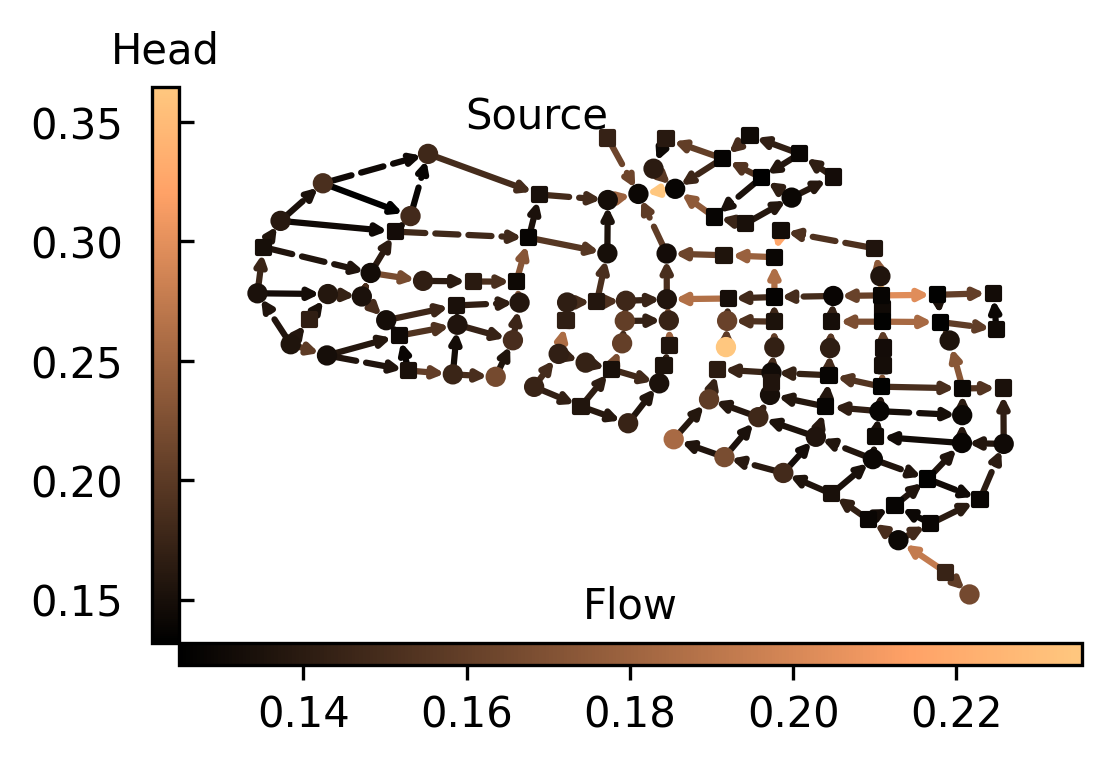

In [18]:
cmap0 = plt.colormaps.get_cmap('copper')
cmap1 = plt.colormaps.get_cmap('copper')
fig, ax = drawing_function_var(np.sqrt(node_all_var), np.sqrt(edge_all_var))